In [2]:
import pandas as pd
import numpy as np

# Load train and test
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Define target columns (these are only in train)
target_cols = [f'BlendProperty{i}' for i in range(1, 11)]

# All input features are those NOT in target columns
feature_cols = [col for col in train.columns if col not in target_cols]

# Now this will work:
X = train[feature_cols]
y = train[target_cols]

# And this won't raise an error anymore:
X_test = test[feature_cols]

from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cat_preds = np.zeros((X_test.shape[0], len(target_cols)))
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = MultiOutputRegressor(CatBoostRegressor(
        iterations=3000,
        learning_rate=0.03,
        depth=6,
        random_state=42,
        verbose=0
    ))
    
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    score = mean_absolute_percentage_error(y_val, val_pred)
    print(f"Fold {fold} MAPE: {score}")
    cv_scores.append(score)
    
    cat_preds += model.predict(X_test) / kf.n_splits

print("Avg CV MAPE:", np.mean(cv_scores))

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
import warnings

warnings.filterwarnings("ignore")

# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_solution.csv")

# Target columns (BlendProperty1 to BlendProperty10)
target_cols = [f'BlendProperty{i}' for i in range(1, 11)]

# Feature columns = all columns in train except targets
feature_cols = [col for col in train.columns if col not in target_cols]

# Prepare training and testing sets
X = train[feature_cols]
y = train[target_cols]
X_test = test[feature_cols]

# Initialize out-of-fold and test predictions
oof_preds = np.zeros((len(X), len(target_cols)))
test_preds = np.zeros((len(X_test), len(target_cols)))

# 5-fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=101)

for fold, (train_idx, valid_idx) in enumerate(kf.split(X, y)):
    print(f"\n--- Fold {fold+1} ---")

    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    # Base model
    model = MultiOutputRegressor(LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.04,
        random_state=101
    ))

    # Train
    model.fit(X_train, y_train)

    # Predict
    oof_preds[valid_idx] = model.predict(X_valid)
    test_preds += model.predict(X_test) / kf.n_splits

    # Evaluate fold
    fold_mape = mean_absolute_percentage_error(y_valid, oof_preds[valid_idx])
    print(f"Fold {fold+1} MAPE: {fold_mape:.4f}")

# Final CV score
cv_score = mean_absolute_percentage_error(y, oof_preds)
print(f"\nOverall CV MAPE: {cv_score:.4f}")

# Prepare submission
submission = sample_submission.copy()
submission[target_cols] = test_preds
submission.to_csv("submission_lgbm.csv", index=False)
print("Saved submission as 'submission_lgbm.csv'")


--- Fold 1 ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12982
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 55
[LightGBM] [Info] Start training from score -0.024000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12982
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 55
[LightGBM] [Info] Start training from score -0.003162
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12982
[LightGBM] [Info] Number of data points in the train set: 1600, number of used features: 55
[LightGBM

from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
import numpy as np

# Final model using best hyperparameters from Optuna or CV
catboost_best_params = {
    "iterations": 500,
    "learning_rate": 0.05,
    "depth": 6,
    "loss_function": "MAE",
    "verbose": 100,
    "random_seed": 42
}

# Wrap in MultiOutputRegressor
final_model = MultiOutputRegressor(
    CatBoostRegressor(**catboost_best_params)
)

# Train on full training data
final_model.fit(X_train, y_train)

# Predict on test set
preds = final_model.predict(X_test)

# Prepare submission DataFrame
submission = pd.DataFrame(preds, columns=target_cols)
submission.insert(0, "ID", test["ID"])
submission.to_csv("catboost_submission.csv", index=False)

print("✅ Submission saved as catboost_submission.csv")

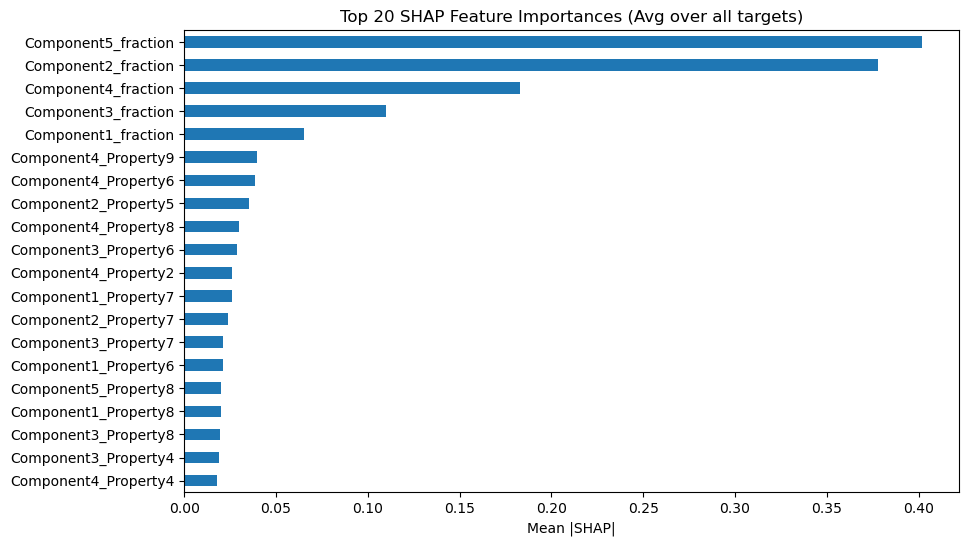

Selected top 30 features out of 55 total.


In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
import shap
import matplotlib.pyplot as plt


# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_solution.csv")

# Target columns (BlendProperty1 to BlendProperty10)
target_cols = [f'BlendProperty{i}' for i in range(1, 11)]

# Feature columns = all columns in train except targets
feature_cols = [col for col in train.columns if col not in target_cols]

# Assume train, test, feature_cols, target_cols are defined

# Prepare data
X = train[feature_cols]
y = train[target_cols]

# Train a single CatBoost model on full data for SHAP
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    verbose=0,
    random_seed=42,
    loss_function='MultiRMSE'
)

model.fit(X, y)

# Calculate SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)



# Compute mean absolute SHAP values across all 10 target outputs
mean_abs_shap = np.abs(shap_values).mean(axis=(0, 2))

# Create feature importance series
feature_importance = pd.Series(mean_abs_shap, index=feature_cols).sort_values(ascending=False)

# Plot top 20 features
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
feature_importance.head(20).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 20 SHAP Feature Importances (Avg over all targets)")
plt.xlabel("Mean |SHAP|")
plt.show()


# Select top N features based on SHAP importance
top_n = 30  # or choose any number you prefer
selected_features = feature_importance.head(top_n).index.tolist()


# Select top N important features
top_n = 30
top_features = feature_importance.head(top_n).index.tolist()

print(f"Selected top {top_n} features out of {len(feature_cols)} total.")

# Redefine datasets with selected features
X_selected = train[selected_features]
X_test_selected = test[selected_features]

In [4]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor

# Select top N features based on SHAP importance
top_n = 45  # or choose any number you prefer
selected_features = feature_importance.head(top_n).index.tolist()

target_cols = [f'BlendProperty{i}' for i in range(1, 11)]

# Feature columns = all columns in train except targets
#feature_cols = [col for col in train.columns if col not in target_cols]


# Updated train and test data
X = train[selected_features]
y = train[target_cols]
X_test = test[selected_features]

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(X)):
    print(f"\nTraining fold {fold}...")
    
    X_tr, X_val = X.iloc[train_idx], X.iloc[valid_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[valid_idx]

    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.05,
        depth=6,
        loss_function='MultiRMSE',
        verbose=0,
        random_seed=42
    )

    model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=50)

    preds = model.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, preds)
    print(f"Fold {fold} MAPE: {mape}")
    cv_scores.append(mape)

print(f"\nAverage CV MAPE after SHAP pruning: {np.mean(cv_scores)}")


Training fold 0...
Fold 0 MAPE: 2.5336383518671473

Training fold 1...
Fold 1 MAPE: 1.6273561736213586

Training fold 2...
Fold 2 MAPE: 1.9142561418290793

Training fold 3...
Fold 3 MAPE: 1.4796278794917046

Training fold 4...
Fold 4 MAPE: 1.0142236069767803

Average CV MAPE after SHAP pruning: 1.7138204307572138


In [ ]:
import optuna
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_percentage_error
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings('ignore')

# Set up data
X = train[feature_cols]
y = train[target_cols]

def objective(trial):
    # Suggest hyperparameters
    params = {
        "iterations": trial.suggest_int("iterations", 300, 1500),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-2, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "verbose": 0,
        "loss_function": "MAE",
        "task_type": "CPU"
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mape_scores = []

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = MultiOutputRegressor(CatBoostRegressor(**params))
        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        score = mean_absolute_percentage_error(y_val, preds)
        mape_scores.append(score)

    return np.mean(mape_scores)

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("\nBest trial:")
print(f"  Value (MAPE): {study.best_value}")
print(f"  Params: {study.best_params}")

[I 2025-07-19 17:27:30,284] A new study created in memory with name: no-name-3faa716e-d924-43fb-8a92-724de2d1d2c4
[I 2025-07-19 17:35:44,770] Trial 0 finished with value: 1.1990546268373534 and parameters: {'iterations': 1470, 'depth': 4, 'learning_rate': 0.01243391942963658, 'l2_leaf_reg': 0.02738019975189505, 'bagging_temperature': 0.4738667397695364, 'random_strength': 4.501946774154073, 'border_count': 219}. Best is trial 0 with value: 1.1990546268373534.
[I 2025-07-19 17:42:57,448] Trial 1 finished with value: 1.661939058961168 and parameters: {'iterations': 718, 'depth': 6, 'learning_rate': 0.12522530541678048, 'l2_leaf_reg': 0.15233052313714385, 'bagging_temperature': 0.2792472749733542, 'random_strength': 9.46721082551309, 'border_count': 170}. Best is trial 0 with value: 1.1990546268373534.
[I 2025-07-19 18:41:24,015] Trial 2 finished with value: 2.435369661998071 and parameters: {'iterations': 1324, 'depth': 9, 'learning_rate': 0.18227809316040836, 'l2_leaf_reg': 7.6518159812

In [1]:
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor

# Use the best hyperparameters from Optuna
best_params = study.best_params
best_params["loss_function"] = "MAE"
best_params["verbose"] = 0
best_params["task_type"] = "CPU"

# Train on full data
final_model = MultiOutputRegressor(CatBoostRegressor(**best_params))
final_model.fit(X, y)

# Predict on test set
X_test = test[feature_cols]
test_preds = final_model.predict(X_test)

# Create submission DataFrame
submission = pd.DataFrame(test_preds, columns=target_cols)
submission.insert(0, 'ID', test['ID'])  # Assuming test set contains 'ID' column

# Save to CSV
submission.to_csv("submission.csv", index=False)

print("Submission file saved as 'submission.csv'")

NameError: name 'study' is not defined

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd


# Load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_solution.csv")


# Define the MLP model
class MLPRegressor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.model(x)

In [10]:
# Target columns (BlendProperty1 to BlendProperty10)
target_cols = [f'BlendProperty{i}' for i in range(1, 11)]

# Feature columns = all columns in train except targets
feature_cols = [col for col in train.columns if col not in target_cols]


# Feature columns = all columns in train except targets
#feature_cols = [col for col in train.columns if col not in target_cols]

# Define input and output matrices
X = train[feature_cols].values
y = train[target_cols].values
X_test = test[feature_cols].values

In [11]:
# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

In [13]:
import numpy as np

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_preds = []
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_tensor)):
    print(f"\nTraining fold {fold}...")
    model = MLPRegressor(input_dim=X.shape[1], output_dim=y.shape[1])
    model.train()

    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    X_train_fold = X_tensor[train_idx]
    y_train_fold = y_tensor[train_idx]
    X_val_fold = X_tensor[val_idx]
    y_val_fold = y_tensor[val_idx]

    # Training loop
    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_fold)
        loss = criterion(outputs, y_train_fold)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            model.eval()
            val_outputs = model(X_val_fold)
            val_loss = criterion(val_outputs, y_val_fold).item()
            print(f"Epoch {epoch+1} - Val Loss: {val_loss:.4f}")

    # Validation
    model.eval()
    val_preds = model(X_val_fold).detach().numpy()
    val_true = y_val_fold.numpy()
    mape_score = mean_absolute_percentage_error(val_true, val_preds)
    print(f"Fold {fold} MAPE: {mape_score}")
    cv_scores.append(mape_score)

    # Save predictions for test
    fold_preds.append(model(X_test_tensor).detach().numpy())

print(f"\n✅ Average CV MAPE: {np.mean(cv_scores)}")


Training fold 0...
Epoch 50 - Val Loss: 0.6522
Epoch 100 - Val Loss: 0.5992
Epoch 150 - Val Loss: 0.5649
Epoch 200 - Val Loss: 0.5428
Fold 0 MAPE: 5.5991621017456055

Training fold 1...
Epoch 50 - Val Loss: 0.6726
Epoch 100 - Val Loss: 0.6083
Epoch 150 - Val Loss: 0.5760
Epoch 200 - Val Loss: 0.5502
Fold 1 MAPE: 3.2597336769104004

Training fold 2...
Epoch 50 - Val Loss: 0.6626
Epoch 100 - Val Loss: 0.6000
Epoch 150 - Val Loss: 0.5648
Epoch 200 - Val Loss: 0.5385
Fold 2 MAPE: 2.8827521800994873

Training fold 3...
Epoch 50 - Val Loss: 0.6713
Epoch 100 - Val Loss: 0.6234
Epoch 150 - Val Loss: 0.5928
Epoch 200 - Val Loss: 0.5681
Fold 3 MAPE: 3.005836009979248

Training fold 4...
Epoch 50 - Val Loss: 0.6849
Epoch 100 - Val Loss: 0.6310
Epoch 150 - Val Loss: 0.5970
Epoch 200 - Val Loss: 0.5686
Fold 4 MAPE: 2.1611876487731934

✅ Average CV MAPE: 3.381734323501587


In [14]:
# Average predictions over folds
final_preds = np.mean(fold_preds, axis=0)

# Create submission
submission = pd.DataFrame(final_preds, columns=target_cols)
submission.insert(0, 'ID', test['ID'])
submission.to_csv("mlp_submission.csv", index=False)
print("✅ MLP submission saved to 'mlp_submission.csv'")

✅ MLP submission saved to 'mlp_submission.csv'
